In [1]:
from __future__ import annotations

from typing import Callable

from stable_baselines3.common.vec_env import DummyVecEnv
from tqdm import tqdm

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from IPython.display import clear_output

import gym
from gym import spaces

from sb3_contrib import RecurrentPPO
from stable_baselines3 import SAC, PPO

from imitation.policies.base import NonTrainablePolicy
from imitation.algorithms.adversarial.gail import GAIL
from imitation.algorithms.adversarial.airl import AIRL
from imitation.data import rollout
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.policies.serialize import load_policy
from imitation.data.types import TransitionsMinimal
from imitation.rewards.reward_nets import BasicRewardNet, BasicShapedRewardNet
from imitation.util.networks import RunningNorm
from imitation.util.util import make_vec_env

from qamsi.config.trading_config import TradingConfig
from qamsi.runner import Runner
from qamsi.strategies.estimated.min_var import MinVariance
from qamsi.cov_estimators.cov_estimators import CovEstimators
from run import Dataset, initialize

In [2]:
REBAL_FREQ = "ME"
DATASET = Dataset.TOPN_US
TOP_N = 30

TRADING_CONFIG = TradingConfig(
    total_exposure=1,
    max_exposure=None,
    min_exposure=None,
    trading_lag_days=1,
)

_, runner = initialize(
    dataset=DATASET,
    trading_config=TRADING_CONFIG,
    topn=TOP_N,
    rebal_freq=REBAL_FREQ,
)

Backtest on 2000-12-29 00:00:00 to 2024-07-31 00:00:00
Num Train Iterations: 283
Num OOS Daily Points: 5932


In [3]:
def vol_to_reward(volatility: float | pd.Series) -> float | pd.Series:
    return -volatility

In [4]:
import gymnasium
from gymnasium import spaces


class BanditEnvironment(gymnasium.Env):
    def __init__(
        self,
        experiment_runner: Runner,
        start_date: pd.Timestamp,
        train_end: pd.Timestamp,
        min_reward: float,
        max_reward: float,
    ) -> None:
        super().__init__()

        self.min_reward = min_reward
        self.max_reward = max_reward

        self.experiment_runner = experiment_runner

        scaler = StandardScaler()

        self.features = self.experiment_runner.features.astype(np.float32)
        scaler.fit(self.features.loc[self.features.index < train_end])
        self.features = scaler.transform(self.features)
        self.features = pd.DataFrame(
            self.features,
            columns=self.experiment_runner.features.columns,
            index=self.experiment_runner.features.index,
            dtype=np.float32,
        )

        self.action_space = spaces.Box(low=0, high=1, dtype=np.float32)

        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(1, self.features.shape[1]),
            dtype=np.float32,
        )

        self.start_dates = self.experiment_runner.returns.simple_returns.loc[
            start_date:
        ].index
        self.end_dates = [
            date + pd.tseries.offsets.BDay(n=21) for date in self.start_dates
        ]

        self.current_id = 0
        self.current_start = self.start_dates[self.current_id]
        self.current_end = self.end_dates[self.current_id]

        self._action_hist = []

    def __len__(self):
        return len(self.start_dates)

    def get_current_id(self):
        return self.current_id

    def get_current_date(self):
        return self.current_start

    def get_current_end_date(self):
        return self.current_end

    def reset(self, *args, **kwargs):
        return self.get_context(), {}

    def get_context(self):
        return self.features.loc[self.current_start].fillna(0).to_numpy().reshape(1, -1)

    def step(
        self, action: np.array
    ) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, dict]:
        action = action[0]

        self._action_hist.append([self.current_end, action])

        estimator = CovEstimators.RISKFOLIO.value(
            alpha=action,
            estimator_type="shrunk",
        )

        strategy = MinVariance(
            cov_estimator=estimator,
            trading_config=self.experiment_runner.trading_config,
            window_size=365,
        )

        fitted_r = self.experiment_runner.run_one_step(
            start_date=self.current_start,
            end_date=self.current_end,
            feature_processor=None,
            strategy=strategy,
        )

        self.current_id += 1
        self.current_start = self.start_dates[self.current_id]
        self.current_end = self.end_dates[self.current_id]

        obs = self.get_context()
        vol = fitted_r.std().item()

        reward = vol_to_reward(vol)
        if self.min_reward is not None and self.max_reward is not None:
            if reward < self.min_reward:
                self.min_reward = reward
            if reward > self.max_reward:
                self.max_reward = reward
            reward = (reward - self.min_reward) / (self.max_reward - self.min_reward)

        done = 1

        return obs, np.array([reward]), np.array([done]), np.array([0.0]), {}

    @property
    def action_hist(self):
        return pd.DataFrame(self._action_hist, columns=["date", "cgp_ucb"]).set_index(
            "date"
        )

    def render(self, mode: str = "human", close: bool = False):
        self.action_hist.plot()

In [5]:
import gymnasium


class OptimalEnvironment(gymnasium.Env):
    def __init__(
        self,
        experiment_runner: Runner,
        true_optimal: pd.DataFrame,
        start_date: pd.Timestamp,
        train_end: pd.Timestamp,
    ) -> None:
        super().__init__()

        self.experiment_runner = experiment_runner
        self.true_optimal = true_optimal

        scaler = StandardScaler()

        self.features = self.experiment_runner.features.astype(np.float32)
        scaler.fit(self.features.loc[self.features.index < train_end])
        self.features = scaler.transform(self.features)
        self.features = pd.DataFrame(
            self.features,
            columns=self.experiment_runner.features.columns,
            index=self.experiment_runner.features.index,
            dtype=np.float32,
        )

        self.optimal_rewards = vol_to_reward(self.true_optimal["vol"]).astype(
            np.float32
        )

        self.action_space = spaces.Box(low=0, high=1, dtype=np.float32)

        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(1, self.features.shape[1]),
            dtype=np.float32,
        )

        self.start_dates = self.experiment_runner.returns.simple_returns.loc[
            start_date:
        ].index
        self.end_dates = [
            date + pd.tseries.offsets.BDay(n=21) for date in self.start_dates
        ]

        self.current_id = 0
        self.current_start = self.start_dates[self.current_id]
        self.current_end = self.end_dates[self.current_id]

        self._action_hist = []

    def __len__(self):
        return len(self.start_dates)

    def get_current_id(self):
        return self.current_id

    def get_current_date(self):
        return self.current_start

    def get_current_end_date(self):
        return self.current_end

    def reset(self, *args, **kwargs):
        return self.get_context(), {}

    def get_context(self):
        return self.features.loc[self.current_start].fillna(0).to_numpy().reshape(1, -1)

    def step(self, action: np.array) -> tuple[np.ndarray, float, float, float, dict]:
        action = action[0]

        self._action_hist.append([self.current_end, action])

        obs = self.get_context()
        reward = self.optimal_rewards[self.current_start]
        done = 1

        self.current_id += 1
        self.current_start = self.start_dates[self.current_id]
        self.current_end = self.end_dates[self.current_id]

        return obs, reward, done, 0.0, {}

    @property
    def action_hist(self):
        return pd.DataFrame(self._action_hist, columns=["date", "cgp_ucb"]).set_index(
            "date"
        )

    def render(self, mode: str = "human", close: bool = False):
        self.action_hist.plot()

In [6]:
class ExpertPolicy(NonTrainablePolicy):
    def __init__(self, env: gym.Env, optimal_policy: pd.Series) -> None:
        super().__init__(
            observation_space=env.observation_space, action_space=env.action_space
        )
        self.policy = optimal_policy.to_numpy()
        self.current_id = 0

    def _choose_action(
        self,
        obs: np.ndarray,
    ) -> np.ndarray:
        action = self.policy[self.current_id].round(1)
        self.current_id += 1
        return np.array([action])


def plot_regret(
    train_regrets: list[float],
    val_regrets: list[float],
):
    clear_output()
    n_cols = 2
    fig, axs = plt.subplots(1, n_cols, figsize=(12, 4))

    if n_cols == 1:
        axs = [axs]

    axs[0].plot(range(1, len(train_regrets) + 1), train_regrets, label="CGP-UCB")
    axs[0].plot(range(1, len(val_regrets) + 1), val_regrets, label="Optimal")
    axs[0].set_ylabel("Rewards")

    train_regrets = np.array(train_regrets)
    val_regrets = np.array(val_regrets)

    axs[1].plot(
        range(1, len(train_regrets) + 1), val_regrets - train_regrets, label="CGP-UCB"
    )
    axs[1].set_ylabel("Regret")

    for ax in axs:
        ax.set_xlabel("epoch")
        ax.legend()

    plt.show()


# Function to initialize an environment instance
def make_env(
    experiment_runner: Runner,
    start_date: pd.Timestamp,
    train_end: pd.Timestamp,
    min_reward: float,
    max_reward: float,
) -> Callable:
    """
    Returns a callable that creates an instance of BanditEnvironment.

    Args:
        experiment_runner: The Runner instance required by the environment.
        start_date: Start date of the environment.
        train_end: Training end date.

    Returns:
        A callable function that creates an environment.
    """

    def _init():
        return BanditEnvironment(
            experiment_runner, start_date, train_end, min_reward, max_reward
        )

    return _init


# Function to initialize an environment instance
def make_optimal_env(
    experiment_runner: Runner,
    true_optimal: pd.DataFrame,
    start_date: pd.Timestamp,
    train_end: pd.Timestamp,
) -> Callable:
    """
    Returns a callable that creates an instance of BanditEnvironment.

    Args:
        experiment_runner: The Runner instance required by the environment.
        start_date: Start date of the environment.
        train_end: Training end date.

    Returns:
        A callable function that creates an environment.
    """

    def _init():
        return RolloutInfoWrapper(
            OptimalEnvironment(experiment_runner, true_optimal, start_date, train_end)
        )

    return _init

In [7]:
START_DATE = "1982-01-01"

start_date = pd.Timestamp(START_DATE)
train_end = pd.Timestamp("1999-12-31")

rebal_dates = runner.init_backtester().rebal_schedule

true_optimal = pd.read_csv("targets.csv")
true_optimal["start_date"] = pd.to_datetime(true_optimal["start_date"])
true_optimal = true_optimal.set_index("start_date")
true_optimal = true_optimal.loc[start_date:]
true_optimal["reward"] = -true_optimal["vol"]

true_optimal_train = true_optimal.loc[true_optimal.index < train_end]
min_reward = true_optimal_train["reward"].min()
max_reward = true_optimal_train["reward"].max()
# min_reward = None
# max_reward = None
if min_reward is not None and max_reward is not None:
    true_optimal["reward"] = (true_optimal["reward"] - min_reward) / (
        max_reward - min_reward
    )

# Number of environments to vectorize (e.g., 4 parallel environments)
n_envs = 1

# Create the vectorized environment using DummyVecEnv
env = DummyVecEnv(
    [
        make_env(runner, start_date, train_end, min_reward, max_reward)
        for _ in range(n_envs)
    ]
)
optimal_env = DummyVecEnv(
    [
        make_optimal_env(runner, true_optimal, start_date, train_end)
        for _ in range(n_envs)
    ]
)

expert = ExpertPolicy(env, true_optimal["shrinkage"].astype(np.float32))
rollouts = rollout.rollout(
    expert,
    optimal_env,
    rollout.make_sample_until(
        min_timesteps=len(true_optimal.loc[true_optimal.index < train_end]),
        min_episodes=None,
    ),
    rng=np.random.default_rng(12),
    verbose=True,
)

Backtest on 2000-12-29 00:00:00 to 2024-07-31 00:00:00
Num Train Iterations: 283
Num OOS Daily Points: 5932


In [8]:
from IPython.display import clear_output

# learner = RecurrentPPO("MlpLstmPolicy", env, verbose=1, device="mps")
learner = SAC("MlpPolicy", env, verbose=0, device="mps")
reward_net = BasicShapedRewardNet(
    observation_space=env.observation_space,
    action_space=env.action_space,
    normalize_input_layer=RunningNorm,
)
trainer = AIRL(
    demonstrations=rollouts,
    demo_batch_size=2048,
    gen_replay_buffer_capacity=512,
    n_disc_updates_per_round=16,
    venv=env,
    gen_algo=learner,
    reward_net=reward_net,
)

train_data = true_optimal.loc[true_optimal.index < train_end]
trainer.train(len(train_data), callback=lambda x: clear_output())

--------------------------------------------------
| mean/                               |          |
|    disc/disc_acc                    | 0.979    |
|    disc/disc_acc_expert             | 0.96     |
|    disc/disc_acc_gen                | 0.998    |
|    disc/disc_entropy                | 0.0712   |
|    disc/disc_loss                   | 0.0763   |
|    disc/disc_proportion_expert_pred | 0.481    |
|    disc/disc_proportion_expert_true | 0.5      |
|    disc/global_step                 | 4.55e+03 |
|    disc/n_expert                    | 2.05e+03 |
|    disc/n_generated                 | 2.05e+03 |
|    gen/rollout/ep_rew_wrapped_mean  | -9.88    |
|    gen/train/actor_loss             | 7.12     |
|    gen/train/critic_loss            | 72.2     |
|    gen/train/ent_coef               | 2.17     |
|    gen/train/ent_coef_loss          | -0.408   |
|    gen/train/learning_rate          | 0.0003   |
|    gen/train/n_updates              | 4.45e+03 |
-------------------------------

round: 100%|██████████| 4549/4549 [37:14<00:00,  2.04it/s]


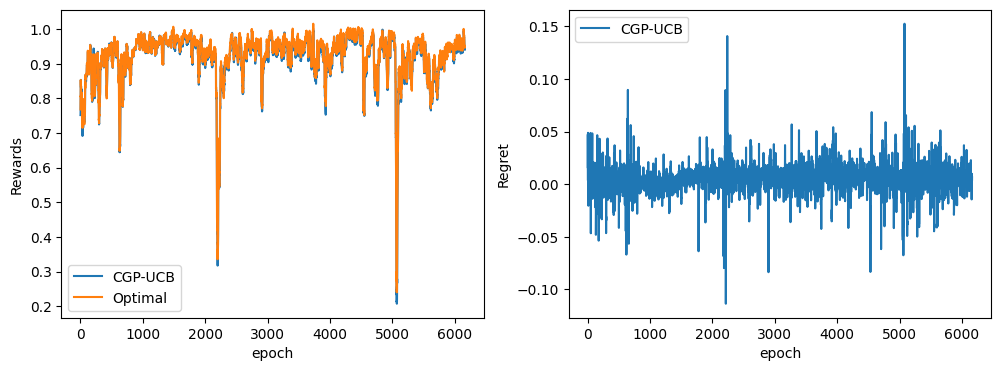

Date: 2024-07-02 00:00:00, Action: 0.249198, Optimal Action: 0.302762, Reward: 0.940423, Optimal Reward: 0.951427:  71%|███████   | 6163/8684 [04:38<01:53, 22.13it/s]


In [9]:
obs = env.reset()
rewards = []
optimal_values = []
optimal_actions = []
last_date = runner.features.index.max()
for t in (pbar := tqdm(range(len(true_optimal) - 2_048))):
    if env.envs[0].get_current_end_date() >= last_date:
        break

    action, _states = trainer.policy.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)

    current_date = env.envs[0].get_current_date()
    true_optimal_action = true_optimal.loc[current_date, "shrinkage"]
    true_optimal_value = true_optimal.loc[current_date, "reward"]

    pbar.set_description(
        f"Date: {current_date}, Action: {action.item():.6f}, Optimal Action: {true_optimal_action:.6f}, Reward: {reward.item():.6f}, Optimal Reward: {true_optimal_value:.6f}"
    )

    # env.action_hist.to_csv("rl.csv", index=True, header=True)

    rewards.append(reward.item())

    true_optimal_action = (
        true_optimal.loc[current_date, "shrinkage"]
        if current_date in true_optimal.index
        else 0.0
    )
    true_optimal_value = (
        true_optimal.loc[current_date, "reward"]
        if current_date in true_optimal.index
        else 0.0
    )

    optimal_values.append(true_optimal_value)
    if t % 20 == 0 and t > 0:
        plot_regret(rewards, optimal_values)

    optimal_actions.append([current_date, action])
    #
    # if t % 20 == 0:
    #     env.action_hist.to_csv("cgp_ucb.csv", index=True, header=True)

In [10]:
true_optimal["reward"]

start_date
1982-01-04    0.908228
1982-01-05    0.913821
1982-01-06    0.909864
1982-01-07    0.905324
1982-01-08    0.907397
                ...   
2024-07-24    0.914784
2024-07-25    0.911159
2024-07-26    0.911756
2024-07-29    0.916969
2024-07-30    0.920438
Name: reward, Length: 10732, dtype: float64

In [11]:
max_reward

-0.0025389185150824

In [12]:
min_reward

-0.0575247175944734

In [13]:
optim = pd.DataFrame(optimal_actions, columns=["date", "irl"]).set_index("date")
optim.to_csv("irl.csv", index=True, header=True)

In [14]:
# env.envs[0].action_hist.to_csv("irl_new.csv", index=True, header=True)

In [15]:
# optim.to_csv("irl.csv", index=True, header=True)

In [16]:
optim

,irl
date,
2000-01-03,[[0.24689865]]
2000-01-04,[[0.21448272]]
2000-01-05,[[0.38547456]]
2000-01-06,[[0.28550544]]
2000-01-07,[[0.2319423]]
...,...
2024-06-26,[[0.26579544]]
2024-06-27,[[0.27544755]]
2024-06-28,[[0.2363298]]


In [17]:
# from qamsi.utils.data import read_csv
#
# optimal_df = read_csv(".", "irl.csv")

In [18]:
optimal = optim.copy()

In [19]:
optimal = optimal.iloc[:, 0]
optimal

date
2000-01-03    [[0.24689865]]
2000-01-04    [[0.21448272]]
2000-01-05    [[0.38547456]]
2000-01-06    [[0.28550544]]
2000-01-07     [[0.2319423]]
                   ...      
2024-06-26    [[0.26579544]]
2024-06-27    [[0.27544755]]
2024-06-28     [[0.2363298]]
2024-07-01    [[0.25697613]]
2024-07-02    [[0.24919811]]
Name: irl, Length: 6163, dtype: object

In [20]:
optimal_ = optimal.apply(lambda x: x.strip("[]"))
optimal_

AttributeError: 'numpy.ndarray' object has no attribute 'strip'

In [33]:
optimal_ = optimal_.astype(float)

<Axes: xlabel='date'>

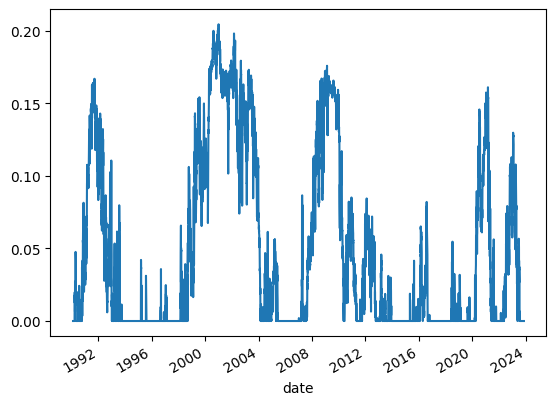

In [34]:
optimal_.plot()

<Axes: xlabel='start_date'>

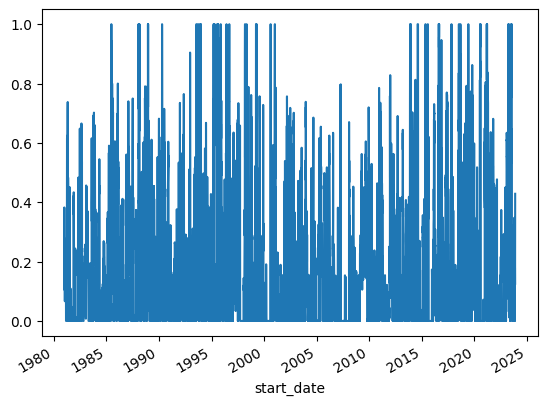

In [39]:
true_optimal["shrinkage"].plot()

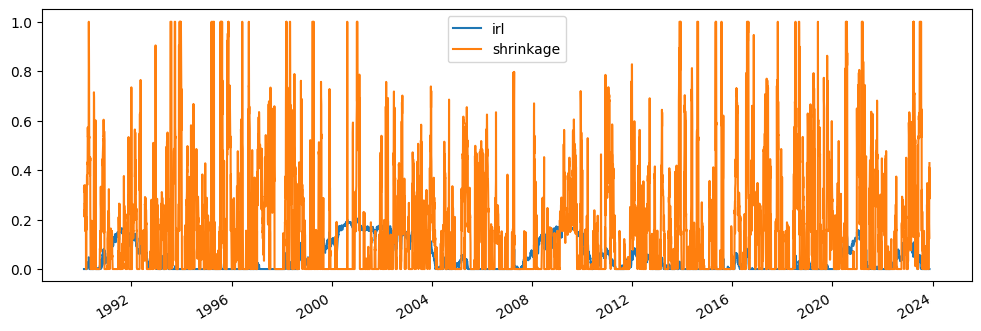

In [41]:
p = optimal_.to_frame("irl").merge(
    true_optimal["shrinkage"], how="inner", left_index=True, right_index=True
)
p.plot(figsize=(12, 4));

In [42]:
optimal_.max()

np.float64(0.20459914)

In [43]:
optimal_.min()

np.float64(0.0)

In [44]:
optimal_.to_frame("irl").to_csv("irl_.csv")